# CitiBike data exploration
This the 'backstage' for the document.

In [1]:
import os, sys
import pandas as pd

# this is to load the file from local path
# I will only load few months of data
# files = ['2013'+ str(x).zfill(2) +' - Citi Bike tripdata.csv' for x in range(7, 13)]
files = ['2014'+ str(x).zfill(2) +'-citibike-tripdata.csv' for x in range(1, 13)]
# files = ['all_trips.csv']
trips = pd.DataFrame()
for file in files:
    df_temp = pd.read_csv(file, parse_dates=['starttime', 'stoptime'],
                    infer_datetime_format=True, low_memory=False)
    trips = trips.append(df_temp, ignore_index=True)
# find the 99.5 quantile, will filter anything above  
trips = trips[trips.tripduration < trips.tripduration.quantile(0.995)]
# the value is about 90 mins
ind = pd.DatetimeIndex(trips.starttime)  # this is very convenient!
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour
trips['trip_id'] = trips.index.values
trips['weekday'] = ind.weekday < 5

total_days = (max(ind) - min(ind)).days + 1
data_year = file[:4]
print('Total number of trips: {}'.format(trips.shape[0]))
trips.columns

Total number of trips: 8040801


Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'date', 'hour', 'trip_id', 'weekday'],
      dtype='object')

### TODO: systematic overview

In [2]:
# percentage of trips taken by subscriber / customer
per = trips.groupby('usertype')['trip_id'].count()['Subscriber'] / trips.shape[0] * 100
print('The percentage of trips taken by subsribers is {:.3f} %'.format(per))

The percentage of trips taken by subsribers is 90.408 %


In [3]:
# percentage of trips taken by gender
print('The percentage of trips taken by male is {:.3f} %'
      .format(100*trips.gender.value_counts()[1] / trips.shape[0]))
print('The percentage of trips taken by female is {:.3f} %'
      .format(100*trips.gender.value_counts()[2] / trips.shape[0]))

The percentage of trips taken by male is 69.929 %
The percentage of trips taken by female is 20.461 %


In [4]:
# age distribution, this only applies to subscriber
import bokeh.plotting as bkp
import bokeh.models as bkm
import bokeh.charts as bkc
from bokeh.layouts import gridplot
import numpy as np

bkp.output_notebook()
count, bin_edges, source = [0, 0], [0, 0], [0, 0]  # initialization
colors = ['navy', 'red']

# fill the \N and 0 entries
df = trips.loc[trips['usertype'] == 'Subscriber', :].copy()
fill_value = df['birth year'].value_counts().index[0]
df['birth year'].replace('\\N', fill_value, inplace = True)
df['birth year'].replace('0', fill_value, inplace = True)

ps = [bkp.figure(plot_height = 300, plot_width = 350, toolbar_location = 'above',
                 tools = 'pan,box_zoom,reset,resize,save',
                 x_axis_label='Age', y_axis_label = 'Total trips')
      for _ in range(2)]
for i, item in enumerate(['Male', 'Female']):
    temp_df = (int(data_year) 
     - df.loc[df['gender'] == i+1,'birth year'].fillna(fill_value).astype(int)).value_counts().to_frame()
    source[i] = bkp.ColumnDataSource(data = dict(
                                        age = temp_df.index,
                                        count = temp_df.iloc[:,0]))
                                     
    ps[i].vbar(x = 'age', top = 'count', width = 0.9, alpha = 0.7, line_alpha = 0.0,
           source = source[i], color = colors[i])
    ps[i].title.text = item
    hover = bkm.HoverTool(tooltips=[('Age','@age{int}'), 
                                    ('Count','@count{int}'), 
                                    ('Percentile','@per{0.0}')])
    ps[i].add_tools(hover)

grid = gridplot([ps])
bkp.output_file('age_distribution_'+str(data_year)+'.html')
bkp.show(grid)
bkp.save(grid)

Loading BokehJS ...

'/Users/changyaochen/Google Drive/python projects/CitiBike/age_distribution_2014.html'

## Time-serise exploration

In [5]:
# what's the distribution of trip duration
bkp.output_notebook()
mask_user, mask_gender, count, bin_edges, source = \
[0, 0],[0, 0], [0, 0], [0, 0], [0, 0]  # initialization

mask_user[0] = (trips.usertype == 'Customer')
mask_user[1] = ~mask_user[0]
mask_gender[0] = trips.gender == 1
mask_gender[1] = trips.gender == 2
ps = [bkp.figure(plot_height = 300, plot_width = 350, toolbar_location = 'above',
                 tools = 'pan,box_zoom,reset,resize,save',
                 x_axis_label='Trip duration (min)', y_axis_label = 'Total trips')
      for _ in range(2)]
for i, item in enumerate(['Customer', 'Subscriber']):
    if i == 0:
        count[i], bin_edges[i] = np.histogram(trips[mask_user[i]].tripduration/60, bins=200)        
        source[i] = bkp.ColumnDataSource(data = dict(bin_value = bin_edges[i][:-1],
                                                     count = count[i], 
                                                     per = 100*np.cumsum(count[i])/sum(count[i])))

        ps[i].vbar(x = 'bin_value', top = 'count', width = 0.5, alpha = 0.7, line_alpha = 0.0,
               source = source[i], color = colors[i])
        ps[i].title.text = item
        hover = bkm.HoverTool(tooltips=[('Duration','@bin_value{0.0}'), 
                                        ('Count','@count{int}'), 
                                        ('Percentile','@per{0.0}')])
        ps[i].add_tools(hover)
    else:
        count[i], bin_edges[i] = [0,0], [0,0]
        count[i][0], bin_edges[i][0] = \
                np.histogram(trips[mask_user[i] & mask_gender[0]].tripduration/60, bins=200) 
        count[i][1], bin_edges[i][1] = \
                    np.histogram(trips[mask_user[i] & mask_gender[1]].tripduration/60, bins=200)
        source[i] = bkp.ColumnDataSource(data = dict(bin_value_male = bin_edges[i][0][:-1],
                                                     count_male = count[i][0], 
                                                     bin_value_female = bin_edges[i][1][:-1],
                                                     count_female = count[i][1], 
                                                     per_male = 100*np.cumsum(count[i][0])/sum(count[i][0]),
                                                     per_female = 100*np.cumsum(count[i][1])/sum(count[i][1]) 
                                                    ))

        tip = ps[i].vbar(x = 'bin_value_male', top = 'count_male', width = 0.5, alpha = 0.7, line_alpha = 0.0,
               source = source[i], color = colors[0], legend = 'Male')
        ps[i].vbar(x = 'bin_value_female', top = 'count_female', width = 0.5, alpha = 0.7, line_alpha = 0.0,
               source = source[i], color = colors[1], legend = 'Female')
        ps[i].title.text = item
        hover = bkm.HoverTool(tooltips=[('Duration','@bin_value_male{0.0}'), 
                                        ('Count, male','@count_male{int}'), 
                                        ('Percentile, male','@per_male{0.0}'),
                                        ('Count, female','@count_female{int}'), 
                                        ('Percentile, female','@per_female{0.0}')],
                             renderers=[tip])
        ps[i].add_tools(hover)
    
grid = gridplot([ps])
bkp.output_file('trip_duration_distribution_'+str(data_year)+'.html')
bkp.show(grid)
bkp.save(grid)

Loading BokehJS ...

INFO:bokeh.core.state:Session output file 'trip_duration_distribution_2014.html' already exists, will be overwritten.


'/Users/changyaochen/Google Drive/python projects/CitiBike/trip_duration_distribution_2014.html'

In [6]:
# now I can do some statisitic about the count(sth)
by_date = trips.pivot_table(values = 'tripduration', index = 'date', 
                            columns = ['usertype'], aggfunc='count')
by_date['dayofweek'] = by_date.index.weekday
weekdays = {0:'Mon', 1:'Tue', 2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}
by_date['dayofweek_str'] = by_date['dayofweek'].map(lambda x: weekdays[x])

In [7]:
source = bkp.ColumnDataSource(by_date)
p = bkp.figure(plot_height = 300, plot_width = 750, toolbar_location = 'above',
               x_axis_type="datetime", tools = 'pan,box_zoom,reset,resize,save,crosshair',
              x_axis_label='Date', y_axis_label = 'Total trips')

p.line(x = 'date', y = 'Customer', source = source, 
       legend = 'Customer ',  # the trailing space is important!
         line_width = 3, color='navy')
#p.circle(x = 'date', y = 'Customer', source = source, 
#        size = 10, alpha = 0.7, color = 'navy', line_color=None,
#        hover_line_color='white')

p.line(x = 'date', y = 'Subscriber', source = source, 
         line_width = 3, color='red', legend = 'Subscriber ') # the trailing space is important!
#p.circle(x = 'date', y = 'Subscriber', source = source, 
#        size = 10, alpha = 0.7, color = 'red', line_color=None,
#        hover_line_color='white')
p.legend.location = "top_left"
hover = bkm.HoverTool(tooltips=[('Day','@dayofweek_str')], mode='vline')
p.add_tools(hover)
bkp.output_file('total_trip_by_day_'+str(data_year)+'.html')
bkp.show(p)
bkp.save(p)

INFO:bokeh.core.state:Session output file 'total_trip_by_day_2014.html' already exists, will be overwritten.


'/Users/changyaochen/Google Drive/python projects/CitiBike/total_trip_by_day_2014.html'

In [8]:
# distribution over weekdays and weekends
by_day = by_date.pivot_table(index = 'dayofweek', 
                             columns = by_date.index.weekofyear + 100*by_date.index.year,
                             values = ['Customer', 'Subscriber'])


In [9]:
ps = [bkp.figure(plot_height = 300, plot_width = 350, toolbar_location = 'above',
                 x_range = [elem for elem in weekdays.values()],
                 tools = 'pan,box_zoom,reset,resize,save',
                  x_axis_label='Day of the week', y_axis_label = 'Daily trips') 
      for _ in range(2)]
colors = ['navy', 'red']
   
for j, item in enumerate(['Customer', 'Subscriber']):
    for i in range(1, by_day[item].shape[1]):
        ps[j].line(x = by_day[item].index.map(lambda x: weekdays[x]), 
                   y = by_day[item].iloc[:,i], 
                   line_width = 2, alpha = 0.1, color = colors[j])
    # plot the mean
    mean = ps[j].line(x = by_day[item].index.map(lambda x: weekdays[x]),
               y = by_day[item].loc[:, 1:].mean(axis = 1), 
               line_width = 3, alpha = 1, color = colors[j])
    ps[j].title.text = item

grid = gridplot([ps])
bkp.output_file('daily_trip_by_week_'+str(data_year)+'.html')
bkp.show(grid)
bkp.save(grid)

INFO:bokeh.core.state:Session output file 'daily_trip_by_week_2014.html' already exists, will be overwritten.


'/Users/changyaochen/Google Drive/python projects/CitiBike/daily_trip_by_week_2014.html'

In [10]:
# (only for year 2013) what is the outlier in the left plot on a Thur?
by_day['Customer'].iloc[0,:].argmax()
# this is July 4th!

201422

In [11]:
by_hour = pd.pivot_table(trips, values = 'tripduration', index = 'hour', 
                         columns = ['usertype', 
                                    ind.weekofyear + 100*ind.year,
                                    ind.weekday < 5], aggfunc = 'count')

In [12]:
ps = [bkp.figure(plot_height = 300, plot_width = 350, toolbar_location = 'above',
                 x_range = (0, 24),
                 tools = 'pan,box_zoom,reset,resize,save',
                  x_axis_label='Hour of the day', y_axis_label = 'Daily trips') 
      for _ in range(2)]  # [weekdays, weekends]
colors = ['navy', 'red']  # ['Customer', 'Subscriber']
days = [5, 2]

for j, item in enumerate(['Customer', 'Subscriber']):
    weeks = by_hour[item].columns.get_level_values(0)
    # plot every week
    for week in weeks:  
        if True in by_hour[item][week].columns:  # plot weekdays
            ps[0].line(x = by_hour[item][week].index, 
                       y = by_hour[item][week][True]/5,
                       line_width = 1, alpha = 0.05, color = colors[j])
        if False in by_hour[item][week].columns:  # plot weekends
            ps[1].line(x = by_hour[item][week].index, 
                       y = by_hour[item][week][False]/2,
                       line_width = 1, alpha = 0.05, color = colors[j])
    # plot mean value in the subplots
    for k, elem in enumerate([True, False]):        
        mean = ps[k].line(x = by_hour[item][week].index, 
                   y = by_hour[item].loc[:,(slice(None), elem)].mean(axis = 1)/days[k],
                   line_width = 3, alpha = 1, color = colors[j], legend = item,
                   name = 'mean')
        ps[k].legend.location = 'top_left'
        hover = bkm.HoverTool(tooltips=[('Hour','@x{int}'), ('Number','@y{0.0}')], 
                              mode='vline', renderers=[mean])
        ps[k].add_tools(hover)
        ps[k].title.text = ['Weekdays', 'Weekends'][k]
    
grid = gridplot([ps])
bkp.output_file('daily_trip_by_hour_'+str(data_year)+'.html')
bkp.show(grid)
bkp.save(grid)

INFO:bokeh.core.state:Session output file 'daily_trip_by_hour_2014.html' already exists, will be overwritten.


'/Users/changyaochen/Google Drive/python projects/CitiBike/daily_trip_by_hour_2014.html'

## Find the busiest stations

In [13]:
# populate a station dataframe
import os
if os.path.exists('stations.csv'):
    stations = pd.read_csv('stations.csv', index_col='id')
else:    
    stations = trips.groupby('start station id')['start station name', 'start station latitude',
           'start station longitude'].aggregate(lambda x: x.value_counts().index[0])
    stations.columns = ['name','lat','long']
    stations.index.name = 'id'
    stations.sort_index(inplace = True)
    stations.to_csv('stations.csv')

In [14]:
station_count = -1*trips.groupby(['start station id'])['tripduration'].count().to_frame()
station_count.rename(columns = {'tripduration' : 'out'}, inplace = True)
station_count.index.rename('station_id', inplace = True)
station_count['in'] = trips.groupby(['end station id'])['tripduration'].count()
station_count['total'] = station_count['in'] - station_count['out']
station_count['diff'] = station_count['in'] + station_count['out']
station_count.sort_values(by = 'total', ascending = False, inplace = True)
station_count['name'] = [stations.loc[x, 'name'] for x in station_count.index]
station_count.rename(index = str, inplace = True)

In [15]:
p = bkp.figure(plot_height = 400, plot_width = 750, toolbar_location = 'above',
               tools = 'pan,box_zoom,reset,resize,save',
               x_range = station_count.index.tolist(),
               y_range = [station_count['out'].min(), station_count['in'].max()],
               x_axis_label='Stations ', y_axis_label = 'Total ins and outs',
               title = 'Total station number: {}. Total days: {}'
               .format(len(station_count), total_days))
source= bkp.ColumnDataSource(station_count)
p.vbar(x = 'station_id', top = 'in', width = 0.9, alpha = 0.5, line_alpha = 0.0,
           source = source, color = 'red', legend = 'In:   +')
p.vbar(x = 'station_id', top = 'out', width = 0.9, alpha = 0.5, line_alpha = 0.0,
           source = source, color = 'navy', legend = 'Out: -')
p.vbar(x = 'station_id', top = 'diff', width = 0.9, alpha = 1.0, line_alpha = 0.0,
           source = source, color = 'black',)
hover = bkm.HoverTool(tooltips=[('Station','@name'), ('Net change:','@diff{0.0}')])
p.add_tools(hover)
# visual optimization
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.ygrid.band_fill_alpha = 0.05
p.ygrid.band_fill_color = "navy"
p.xaxis.major_tick_line_color = None
p.xaxis.major_tick_line_width = None
p.xaxis.minor_tick_line_color = None
p.yaxis.minor_tick_line_width = None
p.xaxis.major_label_text_font_size = '0pt'


bkp.output_file('busiest_stations_'+str(data_year)+'.html')
bkp.show(p)
bkp.save(p)

INFO:bokeh.core.state:Session output file 'busiest_stations_2014.html' already exists, will be overwritten.


'/Users/changyaochen/Google Drive/python projects/CitiBike/busiest_stations_2014.html'

## Spatial exploration

In [16]:
# assgin the route as AAAABBBB, where AAAA is the start station id, and BBBB is of end station
trips['route'] = 10000 * trips['start station id'] + trips['end station id']

In [17]:
pop_route = trips.groupby('route')['usertype'].value_counts().unstack()
pop_route.fillna(0, inplace = True)

In [18]:
# to visualize the most popular routes
ps = [bkp.figure(plot_height = 300, plot_width = 350, toolbar_location = 'above',
                 tools = 'pan,box_zoom,reset,resize,save',
                 x_axis_label='Distinct routes', y_axis_label = 'Daily trips')
      for _ in range(2)]
for i, item in enumerate(['Customer', 'Subscriber']):
    pop_route.sort_values(by = item, ascending = False, inplace = True)
    ps[i].line(x = range(1, len(pop_route)+1), y = pop_route[item].values/total_days,
               #width = 0.5, alpha = 0.5, line_alpha = 0.0,
               color = colors[i])
    ps[i].title.text = item
    hover = bkm.HoverTool(tooltips=[('Route','@x{int}'), ('Count','@y{0.000}')], mode = 'vline')
    ps[i].add_tools(hover)
    
grid = gridplot([ps])
bkp.output_file('distinct_route_'+str(data_year)+'.html')
bkp.show(grid)
bkp.save(grid)

INFO:bokeh.core.state:Session output file 'distinct_route_2014.html' already exists, will be overwritten.


'/Users/changyaochen/Google Drive/python projects/CitiBike/distinct_route_2014.html'

In [68]:
N = 20  # number of N most popular routes
pop_route_list = [0, 0]
for i, item in enumerate(['Customer', 'Subscriber']):
    pop_route.sort_values(by = item, ascending = False, inplace = True)
    pop_route_list[i] = pop_route.index[:N]

ps = [0, 0]  # initilized the list
source = [0, 0]  # initilized the list
colors = ['navy', 'red']  # ['Customer', 'Subscriber']

for i, item in enumerate(['Customer', 'Subscriber']):
    source[i] = bkp.ColumnDataSource(
    data = dict(route = list(map(str, pop_route_list[i])),
                count = pop_route[item].loc[pop_route_list[i]].values/total_days,
                start = [stations.loc[int(x/10000), 'name'] for x in pop_route_list[i]],
                end = [stations.loc[int(x%10000), 'name'] for x in pop_route_list[i]])
    )
    x = list(map(str, source[i].data['route']))
    ps[i] = bkp.figure(plot_height = 300, plot_width = 350, toolbar_location = 'above',
                 tools = 'pan,box_zoom,reset,resize,save', x_range = x,
                 x_axis_label='Route', y_axis_label = 'Daily trips', title = item)
    ps[i].vbar('route', top = 'count', width = 0.8, alpha = 0.7, line_alpha = 0.0,
               source = source[i], color = colors[i])
    ps[i].xaxis.major_label_orientation = np.pi/4   
    hover = bkm.HoverTool(tooltips=[('Start','@start'), ('End','@end'), ('Number','@count{0.0}')])
    ps[i].add_tools(hover)
grid = gridplot([ps])

bkp.output_file('popular_route_'+str(data_year)+'.html')
bkp.show(grid) 
bkp.save(grid)

INFO:bokeh.core.state:Session output file 'popular_route_2014.html' already exists, will be overwritten.


'/Users/changyaochen/Google Drive/python projects/CitiBike/popular_route_2014.html'

In [20]:
# find tripid where the bike's *last* end station is not current start station
# hence is bike is xferred in
# grouped by bikeid
# for debugging purpose, the most used bikeid is 16049
def find_xfer_trip_id_pre_trip(df):
    '''the first trip is removed, and a False value is added later'''
    mask = (df['start station id'].values[1:] != df['end station id'].values[:-1])
    # add False to the first item, and reture a single array
    mask = np.hstack((False, mask))
    return df[mask]['trip_id'].values  # return value is an array, hence capable of groupby

# find tripid where the bike's current end station is not *next* start station
# hence is bike is xferred out
def find_xfer_trip_id_post_trip(df):
    '''the last trip is removed, and a False value is added later'''
    mask = (df['start station id'].values[1:] != df['end station id'].values[:-1])
    # add False to the first item, and reture a single array
    mask = np.hstack((mask, False))
    return df[mask]['trip_id'].values  # return value is an array, hence capable of groupby


In [21]:
# look which stations receive most xfer bike in
from itertools import chain
# to get *ALL* trip_id
by_bike = trips.groupby('bikeid').apply(find_xfer_trip_id_pre_trip)
xfer_trip_ids = list(chain.from_iterable(by_bike.values))
# here I assume the trip_id equals to the origin index
trips_xfer_in = trips[trips['trip_id'].isin(xfer_trip_ids)]

In [22]:
# look which stations donate most xfer bike out
# to get *ALL* trip_id
by_bike = trips.groupby('bikeid').apply(find_xfer_trip_id_post_trip)
xfer_trip_ids = list(chain.from_iterable(by_bike.values))
trips_xfer_out = trips[trips['trip_id'].isin(xfer_trip_ids)]

In [23]:
# let's visualize it!
N = 20  # number of top choices
station_lists = [0, 0]
station_lists[0] = trips_xfer_in.groupby('start station id').apply(
                        lambda x: x['trip_id'].count()).sort_values(ascending = False)[:N]
station_lists[1] = trips_xfer_out.groupby('end station id').apply(
                        lambda x: x['trip_id'].count()).sort_values(ascending = False)[:N]

ps = [0, 0]  # initilized the list
source = [0, 0]  # initilized the list
colors = ['navy', 'red']  # ['Received', 'Donate']
labels = ['Out - In','In - Out']

for i, item in enumerate(['Received', 'Donated']):
    source[i] = bkp.ColumnDataSource(
    data = dict(station = list(map(str, station_lists[i].index)),
                count = station_lists[i].values,
                name = [stations.loc[x, 'name'] for x in station_lists[i].index],
                diff = [(-1)**(i+1)*station_count.loc[str(x), 'diff'] for x in station_lists[i].index]))
                        
    ps[i] = bkp.figure(plot_height = 300, plot_width = 350, toolbar_location = 'above',
                 tools = 'pan,box_zoom,reset,resize,save', 
                 x_range = list(map(str, station_lists[i].index)),
                 x_axis_label='Station id', y_axis_label = 'Counts', title = item)
    show = ps[i].vbar('station', top = 'count', width = 0.8, alpha = 0.5, line_alpha = 0.0,
               source = source[i], color = colors[i])
    ps[i].vbar('station', top = 'diff', width = 0.8, alpha = 1, line_alpha = 0.0,
               source = source[i], color = 'black')
    ps[i].xaxis.major_label_orientation = np.pi/4
    hover = bkm.HoverTool(tooltips=[('Station','@name'), 
                                    (item, '@count'),
                                    (labels[i],'@diff')], renderers=[show] )
    ps[i].add_tools(hover)
grid = gridplot([ps])

bkp.output_file('most_xferred_stations_'+str(data_year)+'.html')
bkp.show(grid) 
bkp.save(grid)

INFO:bokeh.core.state:Session output file 'most_xferred_stations_2014.html' already exists, will be overwritten.


'/Users/changyaochen/Google Drive/python projects/CitiBike/most_xferred_stations_2014.html'

In [24]:
# get distances, first read the matrix
dist_mat = pd.read_csv('dist_matrix.csv', index_col = 'id')
# then I will make a dictionary for all the possible route, for the later fast lookup      
dist_table = {}
# the two for-loops below are expected to be slow... but I will let it pass this time
for i in range(dist_mat.shape[0]):
    for j in range(0, dist_mat.shape[1]):
        dist_table[10000*dist_mat.index[i] + int(dist_mat.columns[j])] = dist_mat.iloc[i,j]
        if dist_mat.iloc[i,j] == 0:  # in the case of round trip, mark it as negative
            dist_table[10000*dist_mat.index[i] + int(dist_mat.columns[j])] = -1

In [25]:
# I need to use .apply to speed things up (by a lot!)
trips['distance'] = trips['route'].apply(lambda x: dist_table[x])  

# calculate the speed: assuming the google maps route, unit is mph
trips['speed'] = trips['distance'] / trips['tripduration']* 3600.0 / 1600

In [26]:
# now let's see some distribution
masks, count, bin_edges, source = [0, 0], [0, 0], [0, 0], [0, 0]  # initialization
colors = ['navy', 'red']
masks[0] = (trips.usertype == 'Customer')
masks[1] = ~masks[0]
ps = [bkp.figure(plot_height = 300, plot_width = 350, toolbar_location = 'above',
                 tools = 'pan,box_zoom,reset,resize,save,crosshair',
                 x_range = (0, 20),
                 x_axis_label='Speed (miles per hour)',
                 y_range = (0, 1),
                 y_axis_label = 'Total count (Normalized)')
      for _ in range(2)]
for i, item in enumerate(['Customer', 'Subscriber']):
    if i == 0:
        count[i], bin_edges[i] = np.histogram(trips[masks[i]].speed, bins=5000)
        source[i] = bkp.ColumnDataSource(data = dict(bin_value = bin_edges[i][:-1],
                                                     count = count[i]/max(count[i][1:]), 
                                                     per = 100*np.cumsum(count[i])/sum(count[i])))
        ps[i].vbar(x = 'bin_value', top = 'count', 
                   width = 0.1, alpha = 0.5, line_alpha = 0.0,
               source = source[i], color = colors[i])
        hover = bkm.HoverTool(tooltips=[('Speed','@bin_value')])
    else:
        count[i], bin_edges[i] = [0,0], [0,0]
        count[i][0], bin_edges[i][0] = np.histogram(
            trips[masks[i] & (trips['gender'] == 1)].speed, bins=5000)
        count[i][1], bin_edges[i][1] = np.histogram(
            trips[masks[i] & (trips['gender'] == 2)].speed, bins=5000)
        source[i] = bkp.ColumnDataSource(data = 
                    dict(bin_value_male = bin_edges[i][0][:-1],
                         count_male = count[i][0]/max(count[i][0][1:]), 
                         per_male = 100*np.cumsum(count[i][0])/sum(count[i][0]),
                         
                         bin_value_female = bin_edges[i][1][:-1],
                         count_female = count[i][1]/max(count[i][1][1:]), 
                         per_female = 100*np.cumsum(count[i][1])/sum(count[i][1])
                        ))
        show = ps[i].vbar(x = 'bin_value_male', top = 'count_male', 
                   width = 0.1, alpha = 0.5, line_alpha = 0.0,
                   source = source[i], color = colors[0], legend = 'Male')
        ps[i].vbar(x = 'bin_value_female', top = 'count_female', 
                   width = 0.1, alpha = 0.5, line_alpha = 0.0,
                   source = source[i], color = colors[1], legend = 'Female')
        hover = bkm.HoverTool(tooltips=[('Speed','@bin_value_male')], renderers=[show])
    
    ps[i].title.text = item
    ps[i].add_tools(hover)
    
grid = gridplot([ps])

bkp.output_file('speed_distribution_'+str(data_year)+'.html')
bkp.show(grid) 
bkp.save(grid)

INFO:bokeh.core.state:Session output file 'speed_distribution_2014.html' already exists, will be overwritten.


'/Users/changyaochen/Google Drive/python projects/CitiBike/speed_distribution_2014.html'

In [69]:
# get the weather information, for each day
weather = pd.read_csv('weather_lite.csv', parse_dates = ['date'], infer_datetime_format = True)
trips = trips.merge(weather, on = 'date', how = 'left')
trips.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'date', 'hour', 'trip_id', 'weekday', 'route',
       'distance', 'speed', 'TAVG_x', 'PRCP_x', 'TAVG_y', 'PRCP_y', 'SNOW'],
      dtype='object')

In [ ]:
# to visualized correlation between weather and trip count
t = trips[trips['usertype'] == 'Subscriber']
t = t.groupby('date')[['trip_id', 'TAVG', 'SNOW']].agg(
    {'trip_id':'count', 'TAVG':'mean', 'SNOW':'mean'})

## Prediction models - given route, guess usertype

In [31]:
# the goal of this first toy model is to predict whether a route is taken by a subscriber
# or a customer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
features = ['tripduration', 'hour', 'distance', 'speed', 'weekday','TAVG', 'PRCP']
target = 'usertype'

df_raw = trips[[*features, target]].copy()
target_mapping = {'Customer':0, 'Subscriber':1}
df_raw['usertype'].replace(target_mapping, inplace = True)

In [32]:
df = df_raw.sample(500000)
df.columns

Index(['tripduration', 'hour', 'distance', 'speed', 'weekday', 'TAVG', 'PRCP',
       'usertype'],
      dtype='object')

In [33]:
# stardarize the input values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df[features])  # for later scaling of test data
df[features] = scaler.transform(df[features])

In [34]:
# Logistic regression
train, test = train_test_split(df, test_size = 0.2)
features = df.columns.tolist()
features.remove(target)

usertype_logistic_model = LogisticRegression()
usertype_logistic_model.fit(train[features], train[target].values)
print('========== Logistic regression ==========')
print('training score is {}'.format(
            usertype_logistic_model.score(train[features], train[target].values)))
print('x-validation score is {}'.format(
            usertype_logistic_model.score(test[features], test[target].values)))

========== Logistic regression ==========
training score is 0.9047925
x-validation score is 0.90429


In [35]:
# # Neural network
# from sklearn.neural_network import MLPClassifier
# train, test = train_test_split(df, test_size = 0.2)
# features = df.columns.tolist()
# features.remove(target)
# 
# usertype_mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100)
# usertype_mlp.fit(train[features], train[target].values)
# print('========== Neural network ==========')
# print('training score is {}'.format(
#             usertype_mlp.score(train[features], train[target].values)))
# print('x-validation score is {}'.format(
#             usertype_mlp.score(test[features], test[target].values)))

In [36]:
# add start, end station id, 
df['start_id'] = trips['start station id']
df['end_id'] = trips['end station id']

In [37]:
# Logistic regression with station ids
train, test = train_test_split(df, test_size = 0.2)
features = df.columns.tolist()
features.remove(target)

usertype_logistic_model_2 = LogisticRegression()
usertype_logistic_model_2.fit(train[features], train[target].values)
print('========== Logistic regression with station ids ==========')
print('training score is {}'.format(
            usertype_logistic_model_2.score(train[features], train[target].values)))
print('x-validation score is {}'.format(
           usertype_logistic_model_2.score(test[features], test[target].values)))

========== Logistic regression with station ids ==========
training score is 0.904905
x-validation score is 0.90572


In [38]:
# # Neural network with station ids
# train, test = train_test_split(df, test_size = 0.2)
# features = df.columns.tolist()
# features.remove(target)
# 
# usertype_mlp_2 = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, verbose = 10)
# usertype_mlp_2.fit(train[features], train[target].values)
# print('========== Neural network with station ids ==========')
# print('training score is {}'.format(
#             usertype_mlp_2.score(train[features], train[target].values)))
# print('x-validation score is {}'.format(
#             usertype_mlp_2.score(test[features], test[target].values)))

In [39]:
# one hoc encoding
df = pd.get_dummies(df, columns=['start_id', 'end_id'])

In [40]:
# Logistic regression with station ids, one hoc encoded
train, test = train_test_split(df, test_size = 0.2)
features = df.columns.tolist()
features.remove(target)

usertype_logistic_model_3 = LogisticRegression()
usertype_logistic_model_3.fit(train[features], train[target].values)
print('========== Logistic regression with station ids one hoc encoded ==========')
print('training score is {}'.format(
            usertype_logistic_model_3.score(train[features], train[target].values)))
print('x-validation score is {}'.format(
           usertype_logistic_model_3.score(test[features], test[target].values)))

========== Logistic regression with station ids one hoc encoded ==========
training score is 0.9136675
x-validation score is 0.9123


In [42]:
features

['tripduration',
 'hour',
 'distance',
 'speed',
 'weekday',
 'TAVG',
 'PRCP',
 'start_id_72',
 'start_id_79',
 'start_id_82',
 'start_id_83',
 'start_id_116',
 'start_id_119',
 'start_id_120',
 'start_id_127',
 'start_id_128',
 'start_id_137',
 'start_id_143',
 'start_id_144',
 'start_id_146',
 'start_id_147',
 'start_id_150',
 'start_id_151',
 'start_id_152',
 'start_id_153',
 'start_id_157',
 'start_id_160',
 'start_id_161',
 'start_id_164',
 'start_id_167',
 'start_id_168',
 'start_id_173',
 'start_id_174',
 'start_id_195',
 'start_id_212',
 'start_id_216',
 'start_id_217',
 'start_id_218',
 'start_id_223',
 'start_id_224',
 'start_id_225',
 'start_id_228',
 'start_id_229',
 'start_id_232',
 'start_id_233',
 'start_id_236',
 'start_id_237',
 'start_id_238',
 'start_id_239',
 'start_id_241',
 'start_id_242',
 'start_id_243',
 'start_id_244',
 'start_id_245',
 'start_id_247',
 'start_id_248',
 'start_id_249',
 'start_id_250',
 'start_id_251',
 'start_id_252',
 'start_id_253',
 'start

In [ ]:
# # Neural network with station ids, one hoc encoded
# train, test = train_test_split(df, test_size = 0.2)
# features = df.columns.tolist()
# features.remove(target)
# 
# usertype_mlp_3 = MLPClassifier(hidden_layer_sizes=(50,), max_iter=50, verbose = 10)
# usertype_mlp_3.fit(train[features], train[target].values)
# print('========== Neural network with station ids one hoc encoded ==========')
# print('training score is {}'.format(
#             usertype_mlp_3.score(train[features], train[target].values)))
# print('x-validation score is {}'.format(
#            usertype_mlp_3.score(test[features], test[target].values)))

In [ ]:
# # Random Forest with station ids, one hoc encoded
# from sklearn.ensemble import RandomForestClassifier
# train, test = train_test_split(df, test_size = 0.2)
# features = df.columns.tolist()
# features.remove(target)
# 
# usertype_rf_3 = RandomForestClassifier(n_estimators=100, 
#                                        criterion='gini',
#                                        max_depth=5,
#                                       verbose = True)
# usertype_rf_3.fit(train[features], train[target].values)
# print('========== Random Forest with station ids one hoc encoded ==========')
# print('training score is {}'.format(
#             usertype_rf_3.score(train[features], train[target].values)))
# print('x-validation score is {}'.format(
#             usertype_rf_3.score(test[features], test[target].values)))

### TODO: is there better way to identify the route, say from an area to another area? Also, how about round-trips,  how many are in and out of Manhattan?

### TODO: make heat map of all the trips, say, with google maps?

### TODO: find the route information, such as distances, then build some statistics such as speed, elevation changes, etc

### TODO: bike-centric exploration, how many times a day that one bike is used? what's the 'lifetime' of a bike?

### TODO: find correlation between trips and weather

### TODO: find the correlations between traveling pattern and other geographic attribute, such as median income?

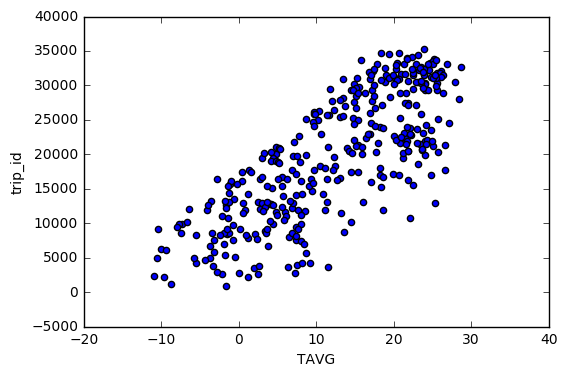

In [66]:
import matplotlib.pyplot as plt
t = trips[trips['usertype'] == 'Subscriber']
t = t.groupby('date')[['trip_id', 'TAVG']].agg({'trip_id':'count', 'TAVG':'mean'})
t.plot.scatter(x = 'TAVG', y = 'trip_id')
plt.show()

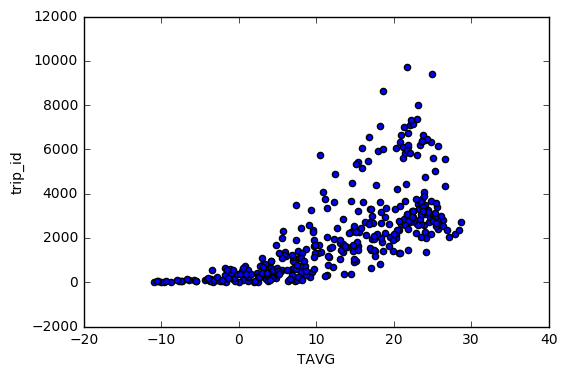

In [67]:
t = trips[trips['usertype'] == 'Customer']
t = t.groupby('date')[['trip_id', 'TAVG']].agg({'trip_id':'count', 'TAVG':'mean'})
t.plot.scatter(x = 'TAVG', y = 'trip_id')
plt.show()

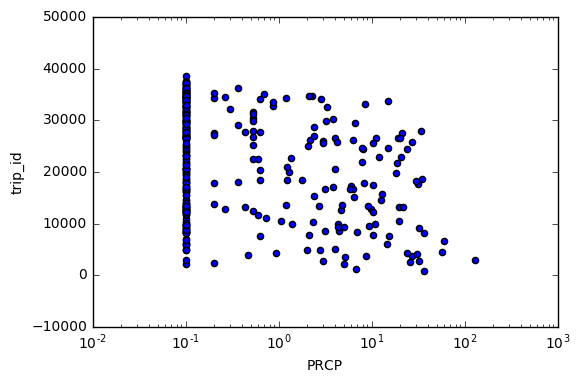

In [63]:
t = trips.groupby('date')[['trip_id', 'PRCP']].agg({'trip_id':'count', 'PRCP':'mean'})
t['PRCP'] += 0.1
t.plot.scatter(x = 'PRCP', y = 'trip_id')
plt.xscale('log')
plt.show()

In [65]:
trips.usertype.value_counts()

Subscriber    7269559
Customer       771242
Name: usertype, dtype: int64

## TODO: prediction model? 
* Idea: given a route, to see whether the rider is a subscriber or a customer
* Idea: given a start station (and other features), where will the rider go
* Idea: predicting the bike inflow-outflow for the next hour
* Idea: where to put new stations?
* Idea: can citibike make more profit, from the customers?
